In [28]:
import numpy as np 
from PIL import Image 
import os 
import cv2 
import math 
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation as R 

In [77]:
# custom class to store image pairs  
class ImagePair:
    def __init__(self, img, pred):
        self.img = img
        self.pred = pred 

    def __repr__(self):
        return f"ImagePair(img={self.img}, pred={self.pred})" 

# custom class to store list of image pairs from directories 
class ImagePairSet:
    def __init__(self, img_dir, pred_dir, img_size):
        self.img_dir = img_dir
        self.pred_dir = pred_dir
        self.img_size = img_size 
        self.img_paths = self.list_images(img_dir) 
        self.pred_paths = self.find_corresponding_preds(pred_dir) 
        self.image_pairs = self.create_image_pairs() 

    def list_images(self, img_dir): 
        # read all images from directory and return list of image paths 
        img_paths = []
        for img in os.listdir(img_dir):
            if img.endswith(".png"):
                img_paths.append(img_dir + img)
        return img_paths 
    
    def find_corresponding_preds(self, pred_dir):
        # find corresponding predictions for each image in img_dir
        pred_paths = []
        for img_path in self.img_paths:
            img_name = img_path.split('/')[-1]
            pred_path = pred_dir + img_name.replace(".png","_prediction.png")
            pred_paths.append(pred_path)
        return pred_paths 
    
    def create_image_pairs(self):
        # create list of image pairs 
        image_pairs = []
        for i in range(len(self.img_paths)):
            img = Image.open(self.img_paths[i])
            # downsize img to img_size 
            img = img.resize(self.img_size, Image.Resampling.LANCZOS) 
            pred = Image.open(self.pred_paths[i])
            image_pairs.append(ImagePair(img, pred))
        return image_pairs

In [89]:
def fit_parallelogram(binary_image):
    binary_image = np.array(binary_image)   
    # Ensure the input image is binary (already thresholded)
    if len(binary_image.shape) == 3:  # In case the image is a color image (unexpected)
        binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
    
    # Find contours from the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    parallelogram_corners = None

    for contour in contours:
        # Check if the contour is large enough to be considered
        area = cv2.contourArea(contour)
        if area < 100:  # Threshold for ignoring small contours (adjust as needed)
            continue

        # Approximate the contour to a polygon (reduce epsilon for higher accuracy)
        epsilon = 0.02 * cv2.arcLength(contour, True)  # Reduce epsilon for more accuracy
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If the contour has more than 4 points, apply convex hull and approximate again
        if len(approx) > 4:
            hull = cv2.convexHull(contour)
            epsilon = 0.02 * cv2.arcLength(hull, True)  # Reduce epsilon for more accuracy
            approx = cv2.approxPolyDP(hull, epsilon, True)
            
            return None # TODO: add way to handle this case by predicting 4th corner  

        # Check if the polygon has 4 sides (quadrilateral)
        if len(approx) == 4:
            parallelogram_corners = approx.reshape(4, 2)
            break  # Stop after finding the first valid parallelogram
    
    return parallelogram_corners

def se3_to_perspective_transform(SE3_matrix, camera_matrix):
    """
    Converts an SE3 (Special Euclidean Group in 3D) transformation matrix to a perspective transformation matrix.

    Parameters:
    - SE3_matrix (np.array): A 4x4 transformation matrix representing the rotation and translation.
    - camera_matrix (np.array): A 3x3 camera intrinsic matrix (e.g., K matrix).

    Returns:
    - np.array: A 3x3 perspective transformation matrix.
    """
    # Extract the rotation matrix (3x3) and translation vector (3x1) from the SE3 matrix
    R = SE3_matrix[:3, :3]  # Rotation matrix
    t = SE3_matrix[:3, 3]   # Translation vector

    # Combine R and t into a 3x4 matrix (Rotation + Translation)
    Rt = np.hstack((R, t.reshape(-1, 1)))  # Combine R and t into a 3x4 matrix

    # Compute the perspective transformation matrix: K * [R | t]
    H = camera_matrix @ Rt  # Perspective transformation matrix (3x3)
    H = H[:3,:3] 

    return H

def marker_reprojection(image, pred, marker_image, marker_corners_2d, marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs, alpha):
    # Load the image and marker image 
    image = np.array(image) 
    if image.shape[2] == 4: 
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB) 
    marker_image = np.array(marker_image) 

    # Project the 3D model points of the marker to the image
    rvec = np.array(rvec, dtype=np.float32) 
    tvec = np.array(tvec, dtype=np.float32) 
    image_points, _ = cv2.projectPoints(marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs)

    # Convert the image points to integer
    image_points = np.round(image_points).astype(int)

    # Draw the marker on the image 
    reprojected_marker_mask = cv2.fillPoly(image*0, [image_points], (255, 255, 255)) 

    image = cv2.addWeighted(image, alpha, pred, 1 - alpha, 0) 

    marker_image_corners = np.array([
        [0, 0],
        [marker_image.shape[1], 0],
        [marker_image.shape[1], marker_image.shape[0]],
        [0, marker_image.shape[0]] 
    ], dtype=np.float32)

    image_points = np.array(image_points).reshape(-1, 2).astype(np.float32) # NOTE: is this needed? 
    M = cv2.getPerspectiveTransform(marker_image_corners, image_points) 

    # define overlay to be each pixel of the marker image transformed using H 
    reprojected_marker_image = cv2.warpPerspective(marker_image, M, (image.shape[1], image.shape[0])) 
    blended_image = cv2.addWeighted(image, 1-alpha, reprojected_marker_image, alpha, 0) 

    return reprojected_marker_image, reprojected_marker_mask, blended_image    

def image_overlap_error(img, img_mask, pred, pred_mask): 

    filter = "mean_threshold" # "min_max", "local", "mean_threshold"

    img = np.array(img) 
    if img.shape[2] == 4:   
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) 
    img_mask = np.array(img_mask) 
    pred = np.array(pred) 
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY) # convert pred to grayscale 
    pred_mask = np.array(pred_mask) 

    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    

    binary_mask = img_mask.copy() 
    binary_mask[binary_mask > 0] = 255 

    masked_pixels = img[img_mask == 255]

    if filter == "min_max": 
        # Find the minimum and maximum pixel values in the masked region
        min_pixel_value = np.min(masked_pixels)
        max_pixel_value = np.max(masked_pixels)

        # normalize img using range of img_mask 
        img_dot_mask = cv2.bitwise_and(img, img_mask)     
        img_filtered = cv2.normalize(img_dot_mask, None, min_pixel_value, max_pixel_value, cv2.NORM_MINMAX) 
    elif filter == "local":
        # TODO: localized regions normalization 
        pass 
    elif filter == "mean_threshold": 
        img_masked_mean = masked_pixels.mean() 
        # threshold img using img_masked_mean as threshold 
        _, img_filtered = cv2.threshold(img_grey, img_masked_mean, 255, cv2.THRESH_BINARY) 
        img_filtered = np.array(img_filtered)

    intersection = cv2.bitwise_and(img_mask, pred_mask) 

    # for each pixel of intersection, compute error between img and pred 
    error = 0 
    for i in range(intersection.shape[0]):
        for j in range(intersection.shape[1]):
            if intersection[i][j][0] == 255:

                # error += np.linalg.norm(img_filtered[i][j] - pred[i][j]) 
                
                if img_filtered[i][j] == pred[i][j]: 
                    error -= 1 
                
                # error += np.sum((img_grey[i][j] - pred[i][j]) ** 2)
    return error 


In [73]:
# define marker corners in marker frame 
marker_img_path = "../synthetic_data_generation/assets/tags/tag36h11_0.png" 
marker_img = cv2.imread(marker_img_path) 
marker_side_length = 0.100 # measured with calipers 
marker_corners_3d = [
    [+marker_side_length/2,+marker_side_length/2,0], 
    [-marker_side_length/2,+marker_side_length/2,0], 
    [-marker_side_length/2,-marker_side_length/2,0], 
    [+marker_side_length/2,-marker_side_length/2,0], 
] 
marker_corners_3d = np.array(marker_corners_3d, dtype=np.float32)

camera = "isaac" # isaac, iphone, ipad 

if camera == "isaac": 
    # assume isaac sim default 
    width = 640 
    height = 480 
    focal_length = 24.0 
    horiz_aperture = 20.955
    # Pixels are square so we can do:
    vert_aperture = height/width * horiz_aperture
    fov = 2 * math.atan(horiz_aperture / (2 * focal_length))
    # compute focal point and center
    fx = width * focal_length / horiz_aperture
    fy = height * focal_length / vert_aperture
    cx = width / 2
    cy = height /2 
else: 
    if camera == "iphone": 
        # assume iphone camera default 
        fx = 2940 / 10000
    if camera == "ipad": 
        # assume ipad camera default 
        fx = 3580  
    fxy = 2940 / 10000 # for iphone camera (approx)
    fxy = 3580 # for ipad camera (approx)
    fx = fxy 
    fy = fxy 
    cx = 640/2  
    cy = 480/2  

camera_matrix = np.array([
    [fx,0,cx],
    [0,fy,cy],
    [0,0,1]
])

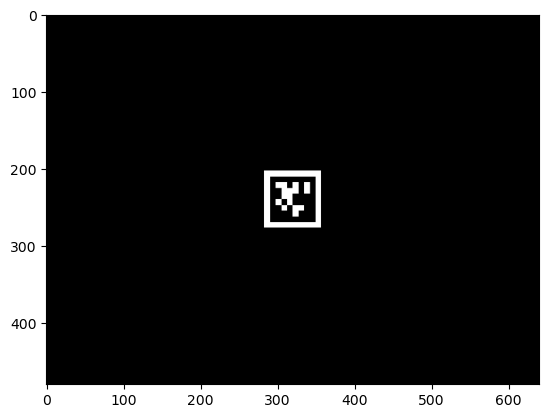

In [108]:
img = np.zeros((480,640,3), dtype=np.uint8) 
pred_np = np.zeros((480,640,3), dtype=np.uint8) 
marker_corners_2d = None 

rotation_vector = np.zeros((3,1)) 
translation_vector = np.array([[0.],[0.],[-1]]) 
dist_coeffs = np.zeros((5,1))   

reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs, 0.8)

plt.imshow(reprojected_marker_image) 
plt.show() 

In [102]:
def xyzabc_to_rvectvec(xyzabc): 
    tvec = xyzabc[:3] 
    rot = R.from_euler("xyz",xyzabc[3:],degrees=True).as_matrix()
    rvec = cv2.Rodrigues(rot)[0] 
    return rvec, tvec 

def sweep_loss_landscape(img, xyzabc_center, xyzabc_range, num_steps): 
    rotation_vector, translation_vector = xyzabc_to_rvectvec(xyzabc_center) 
    rotation_vector = rotation_vector.reshape(3)

    img = np.zeros((480,640,3), dtype=np.uint8) 
    pred_np = np.zeros((480,640,3), dtype=np.uint8) 
    reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs, 0.8)
    img_center = reprojected_marker_image
    img_mask_center = reprojected_marker_mask 
    
    # define array of values to sweep  
    xyzabc_values = np.linspace(xyzabc_center-xyzabc_range, xyzabc_center+xyzabc_range, num_steps) # shape (num_steps,6) 
    loss = np.zeros((xyzabc_values.shape[0],))  

    for i in range(xyzabc_values.shape[0]): 
        xyzabc_val = xyzabc_values[i,:] # shape(6,) 
        rotation_vector, translation_vector = xyzabc_to_rvectvec(xyzabc_val) 
        img = np.zeros((480,640,3), dtype=np.uint8) 
        pred_np = np.zeros((480,640,3), dtype=np.uint8) 
        reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs, 0.8)
        img = reprojected_marker_image
        img_mask = reprojected_marker_mask 
        loss[i] = image_overlap_error(img_center, img_mask_center, img, img_mask)

    return xyzabc_values, loss


Text(0, 0.5, 'loss')

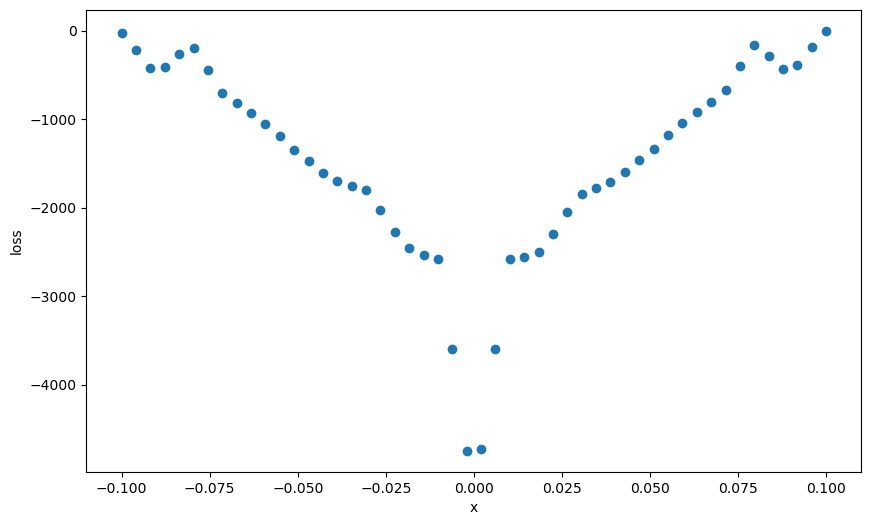

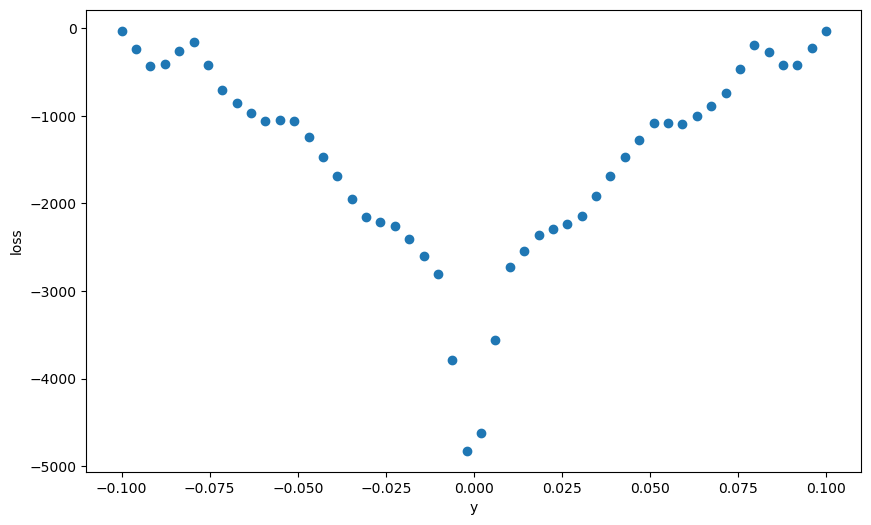

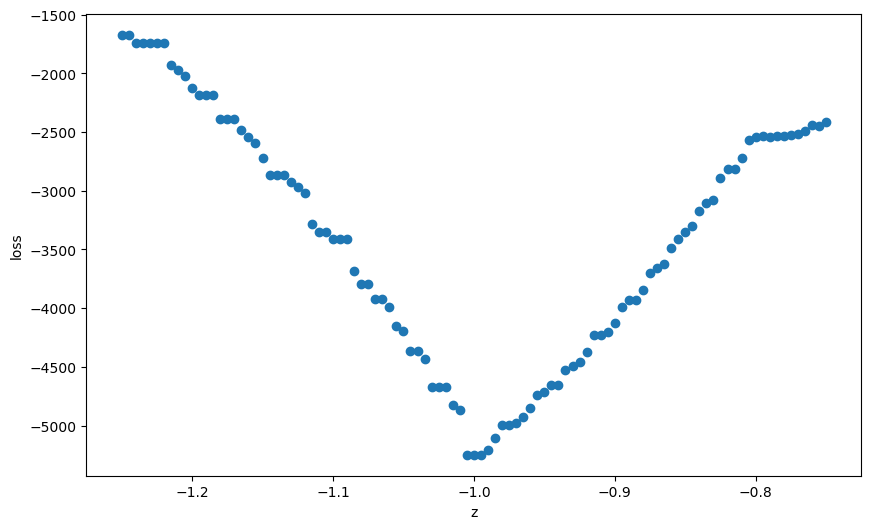

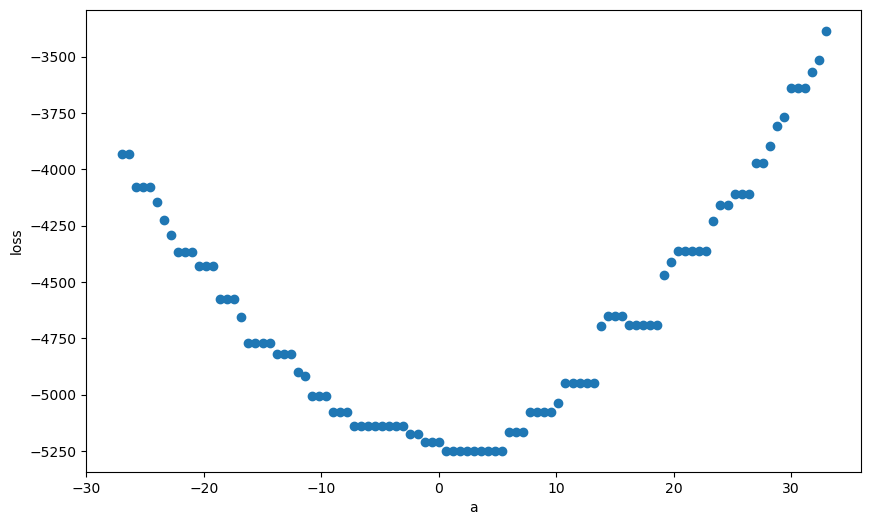

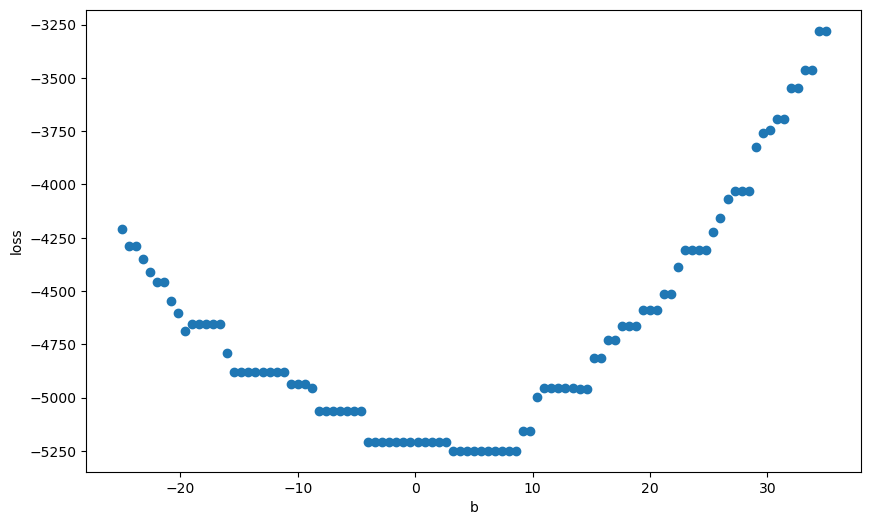

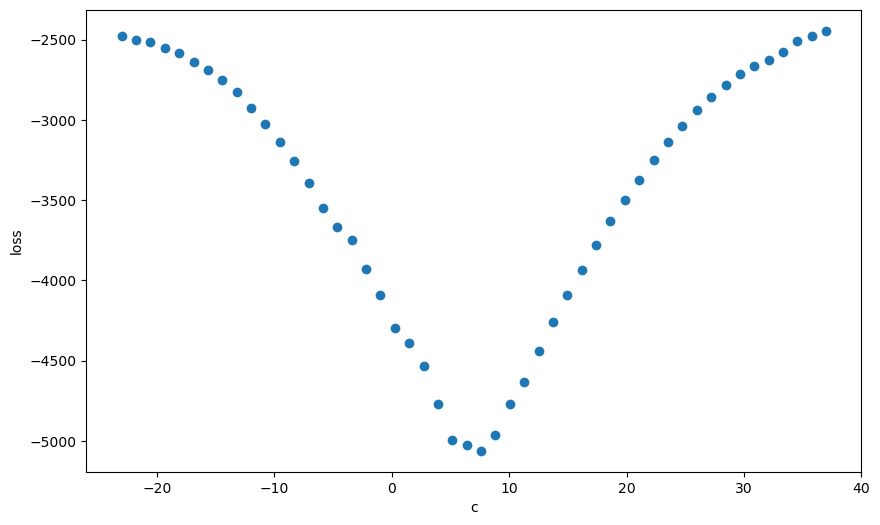

In [109]:
xyzabc_center = np.array([0,0,-1,3,5,7])

xyzabc_range = np.array([0.1,0,0,0,0,0])  
xyzabc_values, loss = sweep_loss_landscape(img, xyzabc_center, xyzabc_range, 50) 
plt.figure(figsize=(10,6))
plt.scatter(xyzabc_values[:,0], loss) 
plt.xlabel("x") 
plt.ylabel("loss") 

xyzabc_range = np.array([0,0.1,0,0,0,0])  
xyzabc_values, loss = sweep_loss_landscape(img, xyzabc_center, xyzabc_range, 50) 
plt.figure(figsize=(10,6))
plt.scatter(xyzabc_values[:,1], loss) 
plt.xlabel("y") 
plt.ylabel("loss") 

xyzabc_range = np.array([0,0,0.25,0,0,0])  
xyzabc_values, loss = sweep_loss_landscape(img, xyzabc_center, xyzabc_range, 101) 
plt.figure(figsize=(10,6))
plt.scatter(xyzabc_values[:,2], loss) 
plt.xlabel("z") 
plt.ylabel("loss") 

xyzabc_range = np.array([0,0,0,30,0,0], dtype=np.float32)  
xyzabc_values, loss = sweep_loss_landscape(img, xyzabc_center, xyzabc_range, 101)
plt.figure(figsize=(10,6))
plt.scatter(xyzabc_values[:,3], loss) 
plt.xlabel("a") 
plt.ylabel("loss") 

xyzabc_range = np.array([0,0,0,0,30,0])  
xyzabc_values, loss = sweep_loss_landscape(img, xyzabc_center, xyzabc_range, 101) 
plt.figure(figsize=(10,6))
plt.scatter(xyzabc_values[:,4], loss) 
plt.xlabel("b") 
plt.ylabel("loss") 

xyzabc_range = np.array([0,0,0,0,0,30])  
xyzabc_values, loss = sweep_loss_landscape(img, xyzabc_center, xyzabc_range, 50) 
plt.figure(figsize=(10,6))
plt.scatter(xyzabc_values[:,5], loss) 
plt.xlabel("c")
plt.ylabel("loss") 


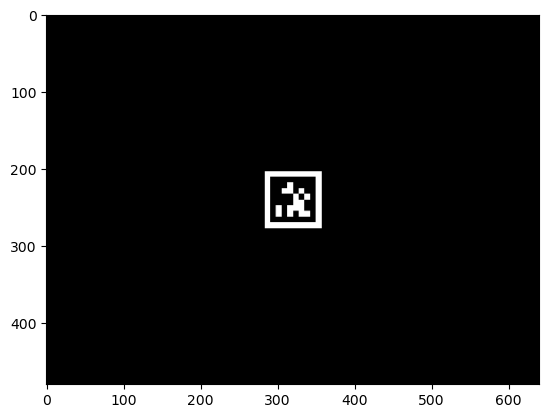

In [97]:
xyzabc_center = np.array([0,0,1,1,0,0], dtype=np.float32) 
rotation_vector, translation_vector = xyzabc_to_rvectvec(xyzabc_center) 
reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs, 0.8)

plt.imshow(reprojected_marker_image) 
plt.show() 